In [ ]:
# Copyright (C) 2020 Artefact
# licence-information@artefact.com

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as
# published by the Free Software Foundation, either version 3 of the
# License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e5/Logo_%C3%A9cole_des_ponts_paristech.svg/676px-Logo_%C3%A9cole_des_ponts_paristech.svg.png" width="200"  height="200" hspace="200"/> </td>
<td> <img src="https://pbs.twimg.com/profile_images/1156541928193896448/5ihYIbCQ_200x200.png" width="200" height="200" /> </td>
</tr></table>

<br/>

<h1><center>Session 6 - Unsupervised modeling</center></h1>



<font size="3">This session is divided into **3** parts:
- **Loading data**
- **Clustering**
- **Topic modeling**

In each of these parts, some **guidelines** and **hints** are given for each task. 
Do not hesitate to check the links to documentation to understand the functions you use. 
    
The goal of this session is to **implement different unsupervised models** to **create clusters** among movies and to see **which topics emerge** from movies description.
</font>

# 0 - Useful libraries

In [103]:
import pandas as pd
import numpy as np
import random as rd
import json
from matplotlib import pyplot as plt

# 1. Loading data

In [106]:
# Load dataset for unsupervised modeling
data = pd.read_csv('dataset_unsupervised.csv')

# Load tagline data
with open('movies_tagline.json', 'r', encoding='utf-8', errors='ignore') as f:
    tagline = json.load(f)
df_tagline = pd.DataFrame.from_dict(tagline, orient='index', columns=['tagline']).reset_index().rename({'index': 'id'}, axis=1)
df_tagline['id'] = df_tagline['id'].astype(int)

# Load overview data
with open('movies_overview.json', 'r', encoding='utf-8', errors='ignore') as f:
    overview = json.load(f)
df_overview = pd.DataFrame.from_dict(overview, orient='index', columns=['overview']).reset_index().rename({'index': 'id'}, axis=1)
df_overview['id'] = df_overview['id'].astype(int)

# Merge datasets
data = data.merge(df_tagline, on='id', how='left').merge(df_overview, on='id', how='left')

# Create dictionary to associate a movie ID to its title (will be used for exploration later)
dict_title = data[['id', 'title']].set_index('id').to_dict()['title']

# Drop variables useless for the modeling part (clustering and topic modeling)
data = data.drop(['release_date', 'title', 'index'], axis=1)

In [107]:
data = data.set_index('id')

In [108]:
data.head()

,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,...,rolling_sales_collection,mean_3_popularity,mean_5_popularity,actor_1_sales,actor_2_sales,actor_3_sales,mean_sales_actor,max_sales_actor,tagline,overview
id,,,,,,,,,,,,,,,,,,,,,
2475,2000,139087,0,25000000.0,120.0,0,0,1,0,0,...,0.0,0.489158,0.373572,0.0,0.0,0.0,0.0,0.0,,Comme les Mousquetaires dont elles possèdent l...
2870,2000,66228,0,22000000.0,142.0,1,0,0,0,0,...,0.0,1.404085,1.229533,0.0,0.0,0.0,0.0,0.0,,"New York, été 1977. Alors que la ville connait..."
2706,2000,1463152,0,25000000.0,77.0,0,1,0,0,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,,
11980,2000,32954,0,25000000.0,116.0,1,0,0,0,0,...,0.0,0.465217,0.346425,0.0,0.0,0.0,0.0,0.0,,"Félicia, dix-sept ans, traverse la mer d'Irlan..."
2480,2000,223564,1,40000000.0,99.0,1,0,0,0,0,...,0.0,2.802817,2.044138,0.0,0.0,0.0,0.0,0.0,Il reprend du service.,Arthur Bishop pensait qu'il avait mis son pass...


# 2. Clustering

In [61]:
# For movie clustering, textual variables are not usefull, let's drop them
data_clustering = data.drop(['overview', 'tagline'], axis=1)

In [62]:
data_clustering.head(2)

,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,...,cos_month,nb_movie_collection,rolling_sales_collection,mean_3_popularity,mean_5_popularity,actor_1_sales,actor_2_sales,actor_3_sales,mean_sales_actor,max_sales_actor
id,,,,,,,,,,,,,,,,,,,,,
2475,2000,139087,0,25000000.0,120.0,0,0,1,0,0,...,1.732051,0.0,0.0,0.489158,0.373572,0.0,0.0,0.0,0.0,0.0
2870,2000,66228,0,22000000.0,142.0,1,0,0,0,0,...,1.732051,0.0,0.0,1.404085,1.229533,0.0,0.0,0.0,0.0,0.0


In [63]:
# Normalize data in order to have a similar scale between all features

# The normalization can be made with sklearn: the StandardScaler object will compute the following operation for each value of all columns
# normalized_x = (x - mean_of_column) / std_of_column

from sklearn.preprocessing import StandardScaler

# We define all the columns that need to be normalized (all columns except binary ones)
cols_to_normalize = ['sales', 'budget', 'year', 'runtime', 'holidays', 'cos_month', 'nb_movie_collection', 'rolling_sales_collection',
                     'mean_3_popularity', 'mean_5_popularity', 'actor_1_sales', 'actor_2_sales', 'actor_3_sales', 'mean_sales_actor',
                     'max_sales_actor']
# We initialize the scaler
scaler = StandardScaler()
# We apply it to all of the columns
scaled_data = scaler.fit_transform(data_clustering[cols_to_normalize]) 
# We copy the scaled data into our main dataframe
data_clustering[cols_to_normalize] = pd.DataFrame(scaled_data)
# We fill potential missing values with zero
data_clustering = data_clustering.fillna(0)

In [64]:
data_clustering.head(2)

,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,...,cos_month,nb_movie_collection,rolling_sales_collection,mean_3_popularity,mean_5_popularity,actor_1_sales,actor_2_sales,actor_3_sales,mean_sales_actor,max_sales_actor
id,,,,,,,,,,,,,,,,,,,,,
2475,-0.415636,0.119701,0,-0.231311,-0.28000,0,0,1,0,0,...,-0.760779,-0.296292,-0.178509,-0.754163,-0.617331,0.139729,0.209824,1.989242,0.954372,0.818345
2870,-0.242612,0.915479,0,2.534904,1.27308,1,0,0,0,0,...,0.668228,5.599524,10.485622,1.262001,1.818067,3.550578,3.102506,0.173101,3.193107,2.718632


In [65]:
# Split the dataset into a train part and a test part (with a ratio 80/20 for example)
# Hint: take a look at the train_test_split() function from sklearn 
# (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_clustering, test_size = 0.2)

## 2.1. K-means

In [66]:
from sklearn.cluster import KMeans

In [67]:
X_test_kmeans = X_test.copy()

In [68]:
# Choose a number k of clusters 
k = 10

In [69]:
# Initialize a K-means model
km = KMeans(n_clusters = k, random_state = 0)

In [70]:
# Fit the K-means model to your data
km = km.fit(X_train)

In [71]:
# Predict on your test set
predictions = km.predict(X_test_kmeans)

In [72]:
# Explore your results
# Hint: merge your predictions with your initial dataset X_test_kmeans and use the dict_title object to retrieve which title is associated to
# each movie ID. From there you will be able to know which movies are in each cluster
X_test_kmeans['id'] = X_test_kmeans.index.astype(int)
X_test_kmeans['prediction'] = predictions
X_test_kmeans['title'] = X_test_kmeans['id'].map(dict_title)

In [73]:
# Print the first 10 movies (identified with their titles) associated to a each cluster
# Hint: use a for loop on the number of clusters and use .loc to find movies that are related to the given cluster
for nb in set(X_test_kmeans['prediction']):
    print('Cluster: ', nb)
    print('Number of movies in cluster: ', len(X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title']))
    print('Titles: ', X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title'][:10])
    print('----- ')

Cluster:  0
Number of movies in cluster:  14
Titles:  id
1780      Ah! Si j'étais riche
1057           L'Enquête corse
2151                   The One
1419          7 ans de mariage
1659       La Légende de Parva
441                     Slevin
1196               Feux rouges
1953    Le Nouveau Jean-Claude
614             Raisons d'Etat
16                    Iron Man
Name: title, dtype: object
----- 
Cluster:  1
Number of movies in cluster:  216
Titles:  id
17238       Memories of Murder
11075      L'Elite de Brooklyn
1988                Auto Focus
496        Expédition Nil bleu
1901          Mission Alcatraz
1496                     Honey
581      L'Ecole des dragueurs
13965              Jersey Boys
10693         Hanté par ses ex
2941       Pour l'amour du jeu
Name: title, dtype: object
----- 
Cluster:  2
Number of movies in cluster:  134
Titles:  id
20771                               Lux Æterna
548                Quelques jours en septembre
14861    Agents très spéciaux - Code U.N.C.L.

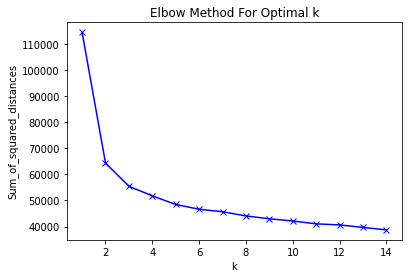

In [74]:
# Try the elbow method to find the optimal number k of clusters. Train a new K-means model with this number, make predictions and explore the
# results
# Hint: use the function plot_elbow() to determine the optimal k

def plot_elbow(X_train, K):
    Sum_of_squared_distances = []
    for k in range(1, K):
        km = KMeans(n_clusters = k, random_state = 0)
        km = km.fit(X_train)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(range(1, K), Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
plot_elbow(X_train, 15)

In [75]:
# Define optimal k and re-train a K-means model
optimal_k = 3
km = KMeans(n_clusters=optimal_k, random_state=0).fit(X_train)

# Make predictions on test set and add corresponding title
X_test_kmeans = X_test.copy()
predictions = km.predict(X_test_kmeans)

# Append predictions and title to the test set
X_test_kmeans['id'] = X_test_kmeans.index.astype(int)
X_test_kmeans['prediction'] = predictions
X_test_kmeans['title'] = X_test_kmeans['id'].map(dict_title)

In [76]:
# Print the first 10 movies associated to a each cluster
for nb in set(X_test_kmeans['prediction']):
    print('Cluster: ', nb)
    print('Number of movies in cluster: ', len(X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title']))
    print('Titles: ', X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title'][:10])
    print('----- ')

Cluster:  0
Number of movies in cluster:  392
Titles:  id
1270     Mon voisin le tueur 2
17238       Memories of Murder
11075      L'Elite de Brooklyn
9865                      13m2
1979        He Arnold! Le film
16935              The Mission
11723                    Conan
13231          Né quelque part
1167                     Exils
1549           1 duplex pour 3
Name: title, dtype: object
----- 
Cluster:  1
Number of movies in cluster:  473
Titles:  id
725                 Les Frères Grimm
20771                     Lux Æterna
11806                Entre nos mains
15585              Kill Your Friends
16285              American Pastoral
19689                 Last Christmas
548      Quelques jours en septembre
1780            Ah! Si j'étais riche
16478                      Willy 1er
19334                     Gemini Man
Name: title, dtype: object
----- 
Cluster:  2
Number of movies in cluster:  471
Titles:  id
17674                  Une saison en France
14805    Une merveilleuse histoire

# 3. Topic modeling

In [77]:
import wordcloud
from nlpretext import Preprocessor
from nlpretext.basic.preprocess import (
    fix_bad_unicode, lower_text, remove_eol_characters, remove_accents, remove_punct, remove_stopwords,
    normalize_whitespace
)

In [78]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-2.3.0/fr_core_news_sm-2.3.0.tar.gz

In [79]:
# Reset ID as a feature and create regular index for data (from 0 to length of data)
data['id'] = data.index.astype(int)
data.index = range(len(data))

In [80]:
# Preprocessing with NLPretext: for python versions < 3.9

custom_stopwords = ['vie', 'ans', 'jeune', 'film', 'femme', 'homme', 'famille', 'pere', 'fille', 'mere', 'monde',
                    'jour', 'ete']

def preprocess(df_text, custom_stopwords=custom_stopwords):
    df_text = df_text.loc[df_text['text'] != ' ']
    df_text['text_prepro'] = df_text['text'].map(fix_bad_unicode)
    df_text['text_prepro'] = df_text['text_prepro'].map(lower_text)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_eol_characters)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_accents)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_punct)
    df_text['text_prepro'] = df_text['text_prepro'].map(lambda x: remove_stopwords(
        x, lang='fr', custom_stopwords=custom_stopwords))
    df_text['text_prepro'] = df_text['text_prepro'].map(normalize_whitespace)
    df_text['tokens'] = df_text['text_prepro'].map(lambda x: x.split())
    return df_text


def make_word_cloud(text_df: pd.DataFrame):
    """
    Function that computes word cloud from tokens

    Parameters
    ----------
    text_df: pd.DataFrame
        dataframe with text column
    cmp: matplotlib.colors.LinearSegmentedColormap
        colormap for the wordcloud
    """
    text = ' '.join([' '.join(el) for el in text_df['tokens']])
    if isinstance(text, str):
        wordcloud_ = wordcloud.WordCloud(background_color='white', width=700, height=500).generate(text)
    else:
        raise TypeError('text_df contains non str values')
    plt.imshow(wordcloud_)
    plt.axis("off")
    plt.show()

### --------------------- To run only if nlpretext installation has failed (Python 3.9)

In [81]:
# Pre-requisites:
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-2.3.0/fr_core_news_sm-2.3.0.tar.gz

import re
import spacy

custom_stopwords = ['vie', 'ans', 'jeune', 'film', 'femme', 'homme', 'famille', 'pere', 'fille', 'mere', 'monde',
                    'jour', 'ete']

def preprocess_no_nlpretext(df_text, custom_stopwords=custom_stopwords):
    df_text = df_text.loc[df_text['text'] != ' ']
    df_text['text_prepro'] = df_text['text'].map(lambda x: x.lower())
    df_text['text_prepro'] = df_text['text_prepro'].map(lambda x: x.replace('\n', ''))
    df_text['text_prepro'] = df_text['text_prepro'].map(lambda x: x.replace("’", ' '))
    df_text['text_prepro'] = df_text['text_prepro'].map(lambda x: re.sub(r'[^\w\s]','', x))
    df_text['text_prepro'] = df_text['text_prepro'].map(lambda x: remove_stopwords_no_nlpretext(x, custom_stopwords=custom_stopwords))
    df_text['text_prepro'] = df_text['text_prepro'].map(normalize_whitespace_no_nlpretext)
    df_text['tokens'] = df_text['text_prepro'].map(lambda x: x.split())
    return df_text

def remove_stopwords_no_nlpretext(text, custom_stopwords):
    sp = spacy.load('fr_core_news_sm')
    stopwords = list(sp.Defaults.stop_words)
    all_stopwords = stopwords + custom_stopwords + ["l", "qu", "peutêtre"]
    return ' '.join([el for el in text.split() if el not in all_stopwords])

def normalize_whitespace_no_nlpretext(text):
    LINEBREAK_REGEX = re.compile(r"((\r\n)|[\n\v])+")
    NONBREAKING_SPACE_REGEX = re.compile(r"(?!\n)\s+")
    text = NONBREAKING_SPACE_REGEX.sub(" ", LINEBREAK_REGEX.sub(r"\n", text)).strip()
    return text

### ---------------------

In [82]:
# Create a 'text' column that is a combination of the tagline and the overview
# Example:
# - tagline = 'Il reprend du service.'
# - overview = 'Arthur Bishop pensait qu'il avait mis son passé de tueur à gages derrière lui. ... etc'
# -> text = 'Il reprend du service. Arthur Bishop pensait qu'il avait mis son passé de tueur à gages derrière lui. ... etc'
data['text'] = data['tagline'] + ' ' + data['overview']

In [83]:
# Explore the results of the preprocessing
# Feel free to change the value of 'i' to see several examples
i = 0

preprocessed_text = preprocess(pd.DataFrame(data.iloc[i]).T)
print('Raw text:', data['text'][i])
print()
print('Preprocessed text:', preprocessed_text['text_prepro'][i])
print()
print('Preprocessed tokens:', preprocessed_text['tokens'][i])

Raw text:  Comme les Mousquetaires dont elles possèdent le cran, l’âme festive et le sens de l’amitié… Ces battantes vivent à Paris et, au premier jour de l’an 2000, elles remettent à l’heure les pendules de leurs vies.  A 35 ans, elles ne croient plus au prince charmant. Leurs carrières théâtrales battent de l’aile et leurs maigres porte-feuilles ne tiennent peut-être qu’à une larme ou un sourire.

Preprocessed text: mousquetaires possedent cran ame festive sens amitie battantes vivent paris an 2000 remettent heure pendules vies 35 croient prince charmant carrieres theatrales battent aile maigres porte feuilles tiennent larme sourire

Preprocessed tokens: ['mousquetaires', 'possedent', 'cran', 'ame', 'festive', 'sens', 'amitie', 'battantes', 'vivent', 'paris', 'an', '2000', 'remettent', 'heure', 'pendules', 'vies', '35', 'croient', 'prince', 'charmant', 'carrieres', 'theatrales', 'battent', 'aile', 'maigres', 'porte', 'feuilles', 'tiennent', 'larme', 'sourire']


In [84]:
# Preprocess the 'text' column:
# - transform the text to lowercase
# - remove end of line characters
# - remove accents
# - remove punctuation
# - remove stopwords
# - split the preprocessed text into words (i.e. tokens) and store it into a new column named 'tokens'

import warnings
warnings.filterwarnings('ignore')

data = preprocess(data)

## 3.1 LDA

In [85]:
import gensim
import gensim.corpora as corpora

In [86]:
# Create a list of all tokens associated to each movie and store it into the variable data_words
data_words = data['tokens'].tolist()
print(data_words[:1][0][:10])

['mousquetaires', 'possedent', 'cran', 'ame', 'festive', 'sens', 'amitie', 'battantes', 'vivent', 'paris']


In [110]:
len(data_words)

6395

In [87]:
# Create a Dictionary based on the all the words per movie
# Hint: explore the gensim library (specifically the 'corpora' section...)
id2word = corpora.Dictionary(data_words)

In [88]:
# Create a Corpus for each text associated to each movie
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [89]:
# Define a number of topics
num_topics = 7

In [90]:
# Train a LDA model
# Hint: explore the gensim library (specifically the 'models' section...)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [91]:
# Print the keywords in the n topics
# Hint: maybe the gensim LDA model has a built-in function to do so...
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.005*"histoire" + 0.003*"ville" + 0.003*"grand" + 0.003*"amour" + '
  '0.003*"amis" + 0.003*"petit" + 0.003*"annees" + 0.003*"jamais" + '
  '0.003*"vit" + 0.002*"temps"'),
 (1,
  '0.005*"histoire" + 0.004*"amour" + 0.003*"petite" + 0.003*"grand" + '
  '0.003*"ville" + 0.003*"enfants" + 0.003*"rencontre" + 0.003*"annees" + '
  '0.002*"petit" + 0.002*"voyage"'),
 (2,
  '0.003*"paris" + 0.003*"amour" + 0.003*"histoire" + 0.003*"passe" + '
  '0.002*"jamais" + 0.002*"maison" + 0.002*"grand" + 0.002*"decide" + '
  '0.002*"nouvelle" + 0.002*"guerre"'),
 (3,
  '0.004*"fils" + 0.003*"passe" + 0.003*"histoire" + 0.003*"grand" + '
  '0.003*"annees" + 0.003*"equipe" + 0.002*"retrouver" + 0.002*"mort" + '
  '0.002*"sauver" + 0.002*"petite"'),
 (4,
  '0.004*"decide" + 0.003*"parents" + 0.003*"rencontre" + 0.003*"petit" + '
  '0.003*"maison" + 0.003*"guerre" + 0.002*"vivre" + 0.002*"aventure" + '
  '0.002*"nouvelle" + 0.002*"grand"'),
 (5,
  '0.004*"histoire" + 0.003*"grand" + 0.003*"amour" 

In [92]:
# Visualize the topics
# Hint: use pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
LDAvis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.008491 -0.052194       1        1  19.886948
5      0.005561 -0.036684       2        1  16.067171
4     -0.034479  0.022304       3        1  15.677988
3      0.002446 -0.038884       4        1  14.353098
0      0.044631  0.032643       5        1  12.522353
2     -0.073538  0.027899       6        1  11.003005
6      0.046889  0.044916       7        1  10.489444, topic_info=          Term        Freq       Total Category  logprob  loglift
1778      amis  461.000000  461.000000  Default  30.0000  30.0000
18       paris  330.000000  330.000000  Default  29.0000  29.0000
94       passe  498.000000  498.000000  Default  28.0000  28.0000
423       nuit  331.000000  331.000000  Default  27.0000  27.0000
2248      alex  151.000000  151.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
54       ville   42.264099  544.871887   Topic7  -6.4259  -0.3018
681   commence   37.196537  331.678192   Topic7  -6.5536   0.0669
751      grand   41.536480  665.833557   Topic7  -6.4432  -0.5197
621      amour   39.382137  637.061340   Topic7  -6.4965  -0.5288
544     guerre   37.914356  391.720886   Topic7  -6.5345  -0.0804

[623 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1504       1  0.063824      10
1504       2  0.164119      10
1504       3  0.127648      10
1504       4  0.091177      10
1504       5  0.373826      10
...      ...       ...     ...
32536      6  0.935321   yuval
20891      2  0.116867  yvonne
20891      4  0.058434  yvonne
20891      7  0.818072  yvonne
32156      6  0.935511    zara

[1673 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 4, 1, 3, 7])

In [93]:
# What are your conclusions regarding the topics? (coherence, stability, ...)

## 3.2 To go further on Topic Modeling: Top2Vec

In [94]:
from top2vec import Top2Vec
# Pre-requisites for top2vec: keras_applications, keras_preprocessing

### 3.2.1 Topics interpretation

In [95]:
# Load the trained Top2Vec model
model_bis = Top2Vec.load('top2vec_imdb.pickle')

# Get information about the model: number of topics found and their sizes
n_topics_found = model_bis.get_num_topics()
topic_sizes, topic_nums = model_bis.get_topic_sizes()

print('Number of topics found:', n_topics_found)
print('Topic sizes:')
for n in range(n_topics_found):
    print('Topic ', n, ' - Size: ', topic_sizes[n])
    print(' ----- ')

Number of topics found: 18
Topic sizes:
Topic  0  - Size:  1559
 ----- 
Topic  1  - Size:  1077
 ----- 
Topic  2  - Size:  641
 ----- 
Topic  3  - Size:  449
 ----- 
Topic  4  - Size:  449
 ----- 
Topic  5  - Size:  354
 ----- 
Topic  6  - Size:  247
 ----- 
Topic  7  - Size:  241
 ----- 
Topic  8  - Size:  235
 ----- 
Topic  9  - Size:  235
 ----- 
Topic  10  - Size:  202
 ----- 
Topic  11  - Size:  193
 ----- 
Topic  12  - Size:  189
 ----- 
Topic  13  - Size:  164
 ----- 
Topic  14  - Size:  142
 ----- 
Topic  15  - Size:  126
 ----- 
Topic  16  - Size:  92
 ----- 
Topic  17  - Size:  81
 ----- 


In [111]:
# Explore the results part 1: check the texts with the best scores in each cluster

# Change "nb" between 0 and 17 to explore each cluster
# Clusters are sorted according to the number of texts they contain (exploring clusters between 0 and 10 may be
# enough to have a good overview of what main clusters represent)
nb = 1

# You can also change the number of texts to display for each cluster with 'num_docs'
num_docs = 7

documents, document_scores, document_ids = model_bis.search_documents_by_topic(topic_num = nb, num_docs = num_docs)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print(doc)
    print("-----------")

Document: 2251, Score: 0.9105080962181091
 Alors qu'il assiste au mariage de son frère, un homme est hanté par les fantômes de ses anciennes petites amies.
-----------
Document: 4459, Score: 0.8830925226211548
 Un photographe de guerre et père absent, qui s'est plus occupé de son appareil photo que de ses 4 filles, coule des jours heureux dans les Alpes avec sa nouvelle compagne. Il va voir sa vie basculer le jour où son meilleur ami va tenter de le réconcilier avec sa famille en leur racontant un gros mensonge.
-----------
Document: 6128, Score: 0.8782322406768799
 Belle, jeune et pleine de doutes, Mavie cherche sa voie. Elle arrive à Paris et y rencontre Georges, libraire au Quartier Latin depuis quarante ans. Solitaire, comme caché dans sa boutique où personne ne vient, Georges l’intrigue et la fascine.  Aussi improbable qu’inattendue, leur histoire d’amour va définitivement transformer le destin de ces deux drôles d’oiseaux.
-----------
Document: 1294, Score: 0.8752090930938721
 A 

Topic 0


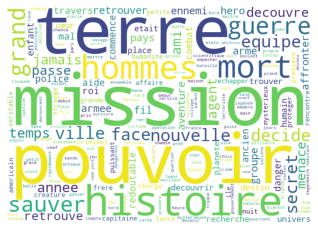

Topic 1


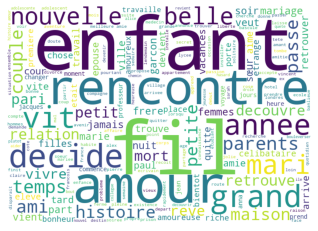

Topic 2


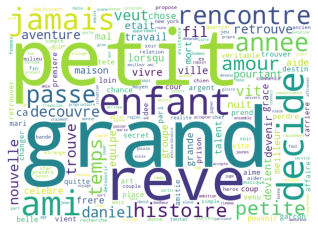

Topic 3


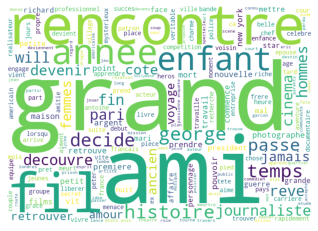

Topic 4


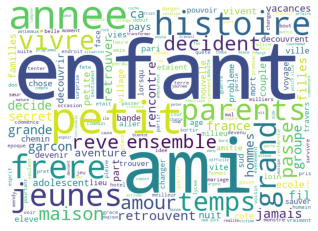

Topic 5


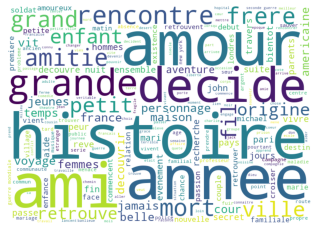

Topic 6


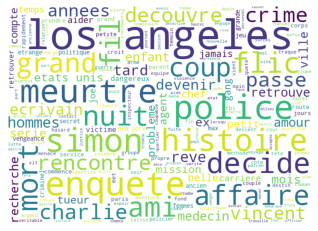

Topic 7


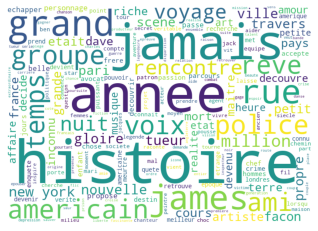

Topic 8


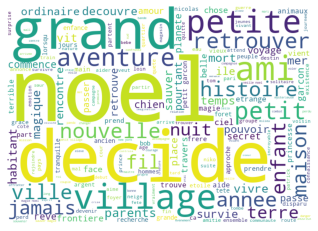

Topic 9


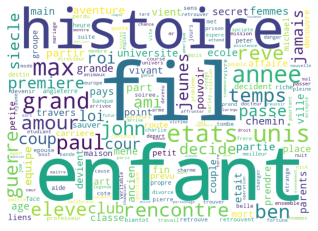

Topic 10


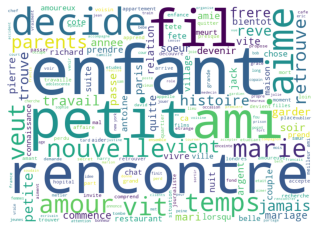

In [97]:
# Explore the results part 2: check the wordclouds associated to each cluster
# Wordclouds are really helpful to have a quick overview of most important words related to each topic
# They can help to interpret each topic

import warnings
warnings.filterwarnings('ignore')

for nb in range(11):
    documents, document_scores, document_ids = model_bis.search_documents_by_topic(topic_num=nb, num_docs=topic_sizes[nb])
    df_text = preprocess(pd.DataFrame(documents, columns=['text']))
    print('Topic', nb)
    make_word_cloud(df_text)

In [98]:
# What would be your interpretation for each cluster ?

# Topic 0: action
# Topic 1: comédie romantique
# Topic 2: drame
# Topic 3: Court-metrage
# Topic 4: histoire de jeunes, duos
# Topic 5: histoire de famille
# Topic 6: flic, los angeles
# Topic 7: histoire, culture
# Topic 8: noël
# Topic 9: aventure
# Topic 10: amour

### 3.2.2 To go further: train your own Top2Vec model

In [99]:
# Create a new dataset for top2vec model, from the 'data' dataframe, do not take movies with empty text 
# into account
data_top2vec = data.loc[(data['text'] != '') & (data['text'].isnull() == False)]

# Make a list from the 'text' column that will contain all texts associated to all movies
all_texts = data_top2vec["text"].tolist()

In [100]:
# Train a top2vec model
model = Top2Vec(documents=all_texts, speed="learn")

2021-03-22 11:25:57,264 - top2vec - INFO - Pre-processing documents for training
2021-03-22 11:26:00,212 - top2vec - INFO - Creating joint document/word embedding
2021-03-22 11:26:52,624 - top2vec - INFO - Creating lower dimension embedding of documents
2021-03-22 11:27:41,252 - top2vec - INFO - Finding dense areas of documents
2021-03-22 11:27:41,791 - top2vec - INFO - Finding topics


In [101]:
# Explore the results:
# - number of topics found
# - topics sizes

n_topics_found = model.get_num_topics()
topic_sizes, topic_nums = model.get_topic_sizes()
print('Number of topics found:', n_topics_found)
print('Topic sizes:')
for n in range(n_topics_found):
    print('Topic ', n, ' - Size: ', topic_sizes[n])
    print(' ----- ')

Number of topics found: 2
Topic sizes:
Topic  0  - Size:  6190
 ----- 
Topic  1  - Size:  205
 ----- 


In [102]:
# Save your model for later if you want to explore it in more details
# model.save('top2vec_imdb_bis.pickle')